# Modeling

In this section, I will develop a final model that will effectively predict whether adding blood glucose test/reagent strips to TG Medical (USA) Inc.'s product line will generate profit for the company.

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, validation_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import joblib

Load in the best model which we found in the previous section along with it's testing and training sets.

In [2]:
model = joblib.load('medical_device_model.pkl')

In [3]:
with open('X_train.pkl', 'rb') as file:
    X_train = pickle.load(file)

In [4]:
with open('y_train.pkl', 'rb') as file:
    y_train = pickle.load(file)

In [5]:
with open('X_test.pkl', 'rb') as file:
    X_test = pickle.load(file)

In [6]:
with open('y_test.pkl', 'rb') as file:
    y_test = pickle.load(file)

Load the data

In [7]:
df = pd.read_csv('Wrangled.csv')

C:\Users\veron\AppData\Local\Temp\ipykernel_35340\2296681516.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Wrangled.csv')


There seems to be an additional column containing the indexes of the DataFrame, we will remove this Unnamed column using the drop() method.

In [8]:
df = df.drop(df.columns[0], axis=1)

We will find the medical device with the most referring providers (most providers ordering this item) using the max() method.

In [9]:
tot_rfrg_prvdrs_max = df['Tot_Rfrg_Prvdrs'].max()
df.loc[df['Tot_Rfrg_Prvdrs'] == tot_rfrg_prvdrs_max]

,Rfrg_Prvdr_Geo_Lvl,Rfrg_Prvdr_Geo_Cd,Rfrg_Prvdr_Geo_Desc,BETOS_Lvl,BETOS_Cd,BETOS_Desc,HCPCS_Cd,HCPCS_Desc,Suplr_Rentl_Ind,Tot_Rfrg_Prvdrs,Tot_Suplrs,Tot_Suplr_Benes,Tot_Suplr_Clms,Tot_Suplr_Srvcs,Avg_Suplr_Sbmtd_Chrg,Avg_Suplr_Mdcr_Alowd_Amt,Avg_Suplr_Mdcr_Pymt_Amt,Avg_Suplr_Mdcr_Stdzd_Amt
592,National,6.0,National,Durable Medical Equipment,D1E,Other DME,A4253,Blood glucose test or reagent strips for home ...,N,233762,43511,1891407.0,5104070,13931820,61.932717,8.400779,5.964003,5.786099


We found that the blood glucose test/reagent strip is the most ordered item, we will create a separate DataFrame for the blood glucose test/reagent strip data.

In [10]:
blood_glucose_test = df[df.HCPCS_Cd == 'A4253']

We will drop the unnecessary columns such as product descriptions and rental information.

In [11]:
blood_glucose_test = blood_glucose_test.drop(columns=['Rfrg_Prvdr_Geo_Lvl', 'Rfrg_Prvdr_Geo_Cd', 'BETOS_Lvl', 'BETOS_Cd', 'BETOS_Desc', 'HCPCS_Desc', 'Suplr_Rentl_Ind'])

In [12]:
blood_glucose_test.head()

,Rfrg_Prvdr_Geo_Desc,HCPCS_Cd,Tot_Rfrg_Prvdrs,Tot_Suplrs,Tot_Suplr_Benes,Tot_Suplr_Clms,Tot_Suplr_Srvcs,Avg_Suplr_Sbmtd_Chrg,Avg_Suplr_Mdcr_Alowd_Amt,Avg_Suplr_Mdcr_Pymt_Amt,Avg_Suplr_Mdcr_Stdzd_Amt
592,National,A4253,233762,43511,1891407.0,5104070,13931820,61.932717,8.400779,5.964003,5.786099
1999,Alabama,A4253,3093,1406,25059.0,64060,181067,56.558110,8.423689,6.055243,5.858798
2624,Alaska,A4253,509,204,2394.0,5877,16216,64.369821,8.403106,5.852651,5.676490
3186,Arizona,A4253,4387,2262,29371.0,70945,207369,66.860627,8.386908,6.101452,5.931097
3987,Arkansas,A4253,2258,924,19444.0,51839,139633,49.084897,8.435714,6.028881,5.825964


Create dummy features for the categorical columns using the get_dummies() method.

In [13]:
dummy_df = pd.get_dummies(blood_glucose_test['Rfrg_Prvdr_Geo_Desc'])

Using the pd.concat() method, we will join the dummy features into the original DataFrame blood_glucose_test.

In [14]:
blood_glucose_test = pd.concat([blood_glucose_test, dummy_df], axis=1)
blood_glucose_test.head()

,Rfrg_Prvdr_Geo_Desc,HCPCS_Cd,Tot_Rfrg_Prvdrs,Tot_Suplrs,Tot_Suplr_Benes,Tot_Suplr_Clms,Tot_Suplr_Srvcs,Avg_Suplr_Sbmtd_Chrg,Avg_Suplr_Mdcr_Alowd_Amt,Avg_Suplr_Mdcr_Pymt_Amt,...,Texas,Unknown,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming
592,National,A4253,233762,43511,1891407.0,5104070,13931820,61.932717,8.400779,5.964003,...,0,0,0,0,0,0,0,0,0,0
1999,Alabama,A4253,3093,1406,25059.0,64060,181067,56.558110,8.423689,6.055243,...,0,0,0,0,0,0,0,0,0,0
2624,Alaska,A4253,509,204,2394.0,5877,16216,64.369821,8.403106,5.852651,...,0,0,0,0,0,0,0,0,0,0
3186,Arizona,A4253,4387,2262,29371.0,70945,207369,66.860627,8.386908,6.101452,...,0,0,0,0,0,0,0,0,0,0
3987,Arkansas,A4253,2258,924,19444.0,51839,139633,49.084897,8.435714,6.028881,...,0,0,0,0,0,0,0,0,0,0


Then drop the original Rfrg_Prvdr_Geo_Desc column containing the categorical values.

In [15]:
blood_glucose_test.drop(['Rfrg_Prvdr_Geo_Desc'], axis=1, inplace=True)
blood_glucose_test.head()

,HCPCS_Cd,Tot_Rfrg_Prvdrs,Tot_Suplrs,Tot_Suplr_Benes,Tot_Suplr_Clms,Tot_Suplr_Srvcs,Avg_Suplr_Sbmtd_Chrg,Avg_Suplr_Mdcr_Alowd_Amt,Avg_Suplr_Mdcr_Pymt_Amt,Avg_Suplr_Mdcr_Stdzd_Amt,...,Texas,Unknown,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming
592,A4253,233762,43511,1891407.0,5104070,13931820,61.932717,8.400779,5.964003,5.786099,...,0,0,0,0,0,0,0,0,0,0
1999,A4253,3093,1406,25059.0,64060,181067,56.558110,8.423689,6.055243,5.858798,...,0,0,0,0,0,0,0,0,0,0
2624,A4253,509,204,2394.0,5877,16216,64.369821,8.403106,5.852651,5.676490,...,0,0,0,0,0,0,0,0,0,0
3186,A4253,4387,2262,29371.0,70945,207369,66.860627,8.386908,6.101452,5.931097,...,0,0,0,0,0,0,0,0,0,0
3987,A4253,2258,924,19444.0,51839,139633,49.084897,8.435714,6.028881,5.825964,...,0,0,0,0,0,0,0,0,0,0


Using LabelEncoder() method to convert the HCPCS_Cd column to a numerical value.

In [16]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
blood_glucose_test['HCPCS_Cd'] = label_encoder.fit_transform(blood_glucose_test['HCPCS_Cd'])

We will now split our dataset into features (X) and the target variable - purchasing price (y)

In [17]:
X = blood_glucose_test.drop(columns='Avg_Suplr_Sbmtd_Chrg')
y = blood_glucose_test['Avg_Suplr_Sbmtd_Chrg']

Refit model on all avaiable data

In [18]:
len(X), len(y)

(59, 59)

In [19]:
model.fit(X, y)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=10, random_state=47))])

In [20]:
cv_results = cross_validate(model, X, y, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [21]:
cv_results['test_score']

array([-4.32113698, -3.8112677 , -4.11292416, -2.52980359, -4.2021928 ])

In [22]:
mae_mean, mae_std = np.mean(-1 * cv_results['test_score']), np.std(-1 * cv_results['test_score'])
mae_mean, mae_std

(3.795465049697726, 0.6549331840211458)

### Linear Regression Model

In [23]:
LR_model = LinearRegression()
LR_model.fit(X_train, y_train)
y_pred_lr = LR_model.predict(X_test)
mean_mse_lr = mean_squared_error(y_test, y_pred_lr)
print("Mean Squared Error:", mean_mse_lr)

Mean Squared Error: 12.991051627034118


In [24]:
rmse_lr = np.sqrt(mean_mse_lr)
print("Root Mean Square Error (RMSE):", rmse_lr)

Root Mean Square Error (RMSE): 3.604310145788528


### Gradient Boosting Regression Model

In [25]:
from sklearn.ensemble import GradientBoostingRegressor

param_grid_gbr = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7]
}
grid_search_gbr = GridSearchCV(GradientBoostingRegressor(random_state=47), param_grid_gbr, cv=5, scoring='neg_mean_squared_error')
grid_search_gbr.fit(X_train, y_train)
best_params_gbr = grid_search_gbr.best_params_
print(best_params_gbr)

{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}


In [26]:
gbr_model = GradientBoostingRegressor(n_estimators=150, learning_rate=0.01, max_depth=3, random_state=47)
gbr_model.fit(X_train, y_train)
y_pred_gbr = gbr_model.predict(X_test)
mean_mse_gbr = mean_squared_error(y_test, y_pred_gbr)
print("Mean Squared Error:", mean_mse_gbr)

Mean Squared Error: 17.130138010571216


In [27]:
rmse_gbr = np.sqrt(mean_mse_gbr)
print("Root Mean Square Error (RMSE):", rmse_gbr)

Root Mean Square Error (RMSE): 4.138857089894651


### Random Forest Regression Model

In [28]:
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}
grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=47), param_grid_rf, cv=5, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train, y_train)
best_params_rf = grid_search_rf.best_params_
print(best_params_rf)

{'max_depth': 7, 'min_samples_split': 10, 'n_estimators': 150}


In [29]:
rf_model = RandomForestRegressor(n_estimators=150, max_depth=7, min_samples_split=10, random_state=47)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mean_mse_rf = mean_squared_error(y_test, y_pred_rf)
print("Mean Squared Error:", mean_mse_rf)

Mean Squared Error: 17.553440650364823


In [30]:
rmse_rf = np.sqrt(mean_mse_rf)
print("Root Mean Square Error (RMSE):", rmse_rf)

Root Mean Square Error (RMSE): 4.18968264315626


In [31]:
myLabels = [ 'Linear Regression','Gradient Boost','Random Forest']
score = [  rmse_lr,rmse_gbr,rmse_rf]
Accuracy_score = [mean_mse_lr,mean_mse_gbr,mean_mse_rf]

score_tab_acc = pd.DataFrame(list(zip(myLabels, Accuracy_score)), 
               columns =['Algorithm', 'Model accuracy score']) 

score_tab = pd.DataFrame(list(zip(myLabels, score)), 
               columns =['Algorithm', 'CV_Score' ]) 
print(score_tab_acc)

score_tab

           Algorithm  Model accuracy score
0  Linear Regression             12.991052
1     Gradient Boost             17.130138
2      Random Forest             17.553441


,Algorithm,CV_Score
0,Linear Regression,3.604310
1,Gradient Boost,4.138857
2,Random Forest,4.189683


Linear Regression appears to perform the best among the three algorithms as it has the lowest score. However, when considering cross-validated scores, Gradient Boost and Random Forest seem to perform better than Linear Regression as they have higher cv_scores but higher cv_scores also indicate slightly worse generalization performance compared to Linear Regression.

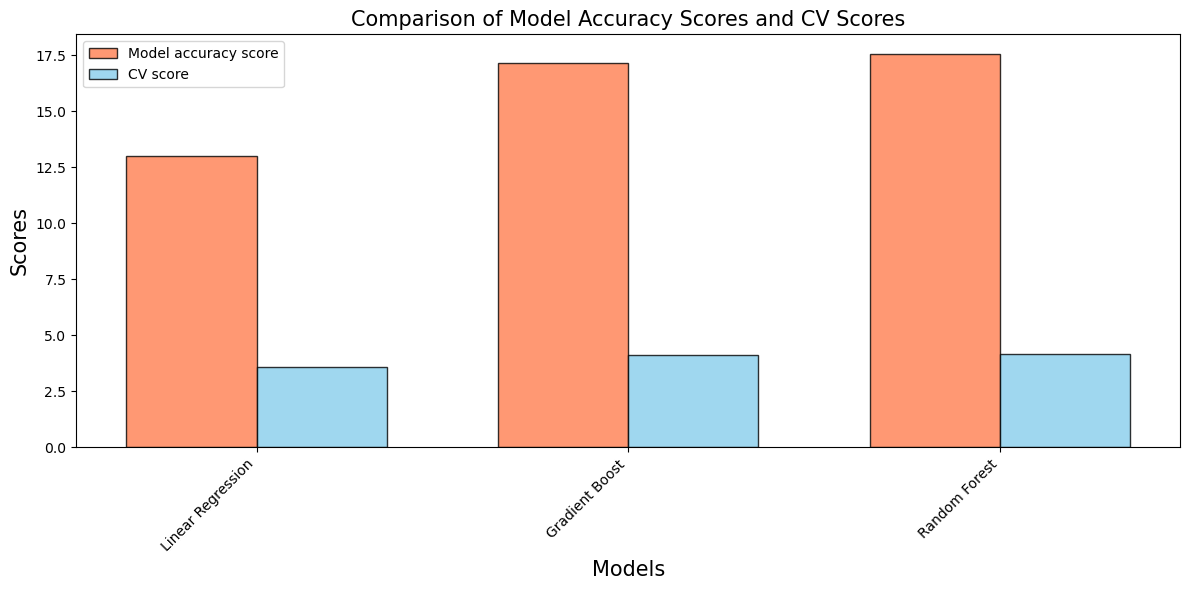

In [32]:
bar_width = 0.35
r1 = np.arange(len(myLabels))
r2 = [x + bar_width for x in r1]
plt.figure(figsize=(12, 6))
plt.bar(r1, Accuracy_score, color='coral', width=bar_width, edgecolor='k', alpha=0.8, label='Model accuracy score')
plt.bar(r2, score, color='skyblue', width=bar_width, edgecolor='k', alpha=0.8, label='CV score')
plt.xlabel('Models', fontsize=15)
plt.ylabel('Scores', fontsize=15)
plt.title('Comparison of Model Accuracy Scores and CV Scores', fontsize=15)
plt.xticks([r + bar_width/2 for r in range(len(myLabels))], myLabels, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Finding the feature coefficients

In [34]:
feature_coefficients = LR_model.coef_
for i, coefficient in enumerate(feature_coefficients):
    print(f"Feature {i}: {coefficient}")

Feature 0: 0.004749339307335926
Feature 1: -0.0011913148993221024
Feature 2: 0.0012396449647345098
Feature 3: -0.00020049927059757276
Feature 4: 8.78146307437184e-05
Feature 5: 1.1295702996912127e-05
Feature 6: -4.312981736012178
Feature 7: -7.308999043871914
Feature 8: -4.091287491198739
Feature 9: -2.806563070362122
Feature 10: 3.5285572058833443
Feature 11: 8.414126637672721
Feature 12: -10.536759013304176
Feature 13: -1.9179526258824486
Feature 14: 5.508134945241974
Feature 15: 0.15458796637400507
Feature 16: -1.4792786490581271
Feature 17: 8.152568063294165
Feature 18: 8.718133249529586
Feature 19: -2.418607342027196
Feature 20: -1.1820801724294254
Feature 21: 0.6420787013270584
Feature 22: -0.1106610185813055
Feature 23: 6.70254548922244
Feature 24: 2.4424906541753444e-15
Feature 25: -1.7841784076785223
Feature 26: 8.881784197001252e-16
Feature 27: 0.6412218825992944
Feature 28: -4.725240392476794
Feature 29: -4.920399590338272
Feature 30: -1.7763568394002505e-15
Feature 31: -5.6

In [36]:
X_train_array = X_train.to_numpy()
top_features_indices = feature_coefficients.argsort()[-5:]
selected_features = X_train.iloc[:, top_features_indices]

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer

In [38]:
preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_regression, k=5)),
    ('model', LinearRegression())
])

In [39]:
pipeline.fit(X_train, y_train)
val_predictions = pipeline.predict(X_val)

In [40]:
val_mse = mean_squared_error(y_val, val_predictions)
print("Validation MSE:", val_mse)

Validation MSE: 25.976890440617325


In [41]:
test_predictions = model.predict(X_test)
test_mse = mean_squared_error(y_test, test_predictions)
print("Test MSE:", test_mse)

Test MSE: 3.7461880052871277


In [42]:
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_scores = -cv_scores
print("Cross-Validation MSE Scores:", cv_scores)
print("Mean MSE:", np.mean(cv_scores))
print("Standard Deviation of MSE:", np.std(cv_scores))

Cross-Validation MSE Scores: [35.67667425 15.09170926 18.09767668 33.0219246  16.19851031]
Mean MSE: 23.617299018203152
Standard Deviation of MSE: 8.85512112449033


In [43]:
from sklearn.metrics import r2_score

In [44]:
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_val)
test_predictions = model.predict(X_test)

train_mse = mean_squared_error(y_train, train_predictions)
val_mse = mean_squared_error(y_val, val_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

train_r2 = r2_score(y_train, train_predictions)
val_r2 = r2_score(y_val, val_predictions)
test_r2 = r2_score(y_test, test_predictions)

print("Train MSE:", train_mse)
print("Validation MSE:", val_mse)
print("Test MSE:", test_mse)

print("Train R2 Score:", train_r2)
print("Validation R2 Score:", val_r2)
print("Test R2 Score:", test_r2)

Train MSE: 3.866538869605473
Validation MSE: 5.111203427959549
Test MSE: 3.7461880052871277
Train R2 Score: 0.8463407132970207
Validation R2 Score: 0.8899563587190521
Test R2 Score: 0.7593648624604183


The model appears to perform well on the training set as indicated by the relatively low training MSE and high training R2 score. This suggests that the model explains approximately 81% of the variance in the training data. The similar R2 scores for the validation and test sets indicate that the model's performance generalizes well to unseen data.